<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/master/kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ■ Overview
- local leel model のフィルタ (Kalman filter) による状態の推定

## ■ Reference
- [カルマンフィルタの考え方 | Logics of Blue](https://logics-of-blue.com/kalman-filter-concept/)

## ■ Import

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## ■ My function

In [2]:
# カルマンフィルタ
def local_level_model(y, x_pre, p_pre, sigma_w, sigma_v):
    # 状態の予測
    x_forecast = x_pre

    # 状態の予測誤差の分散
    p_forecast = p_pre + sigma_w

    # カルマンゲイン
    k_gain = p_forecast / (p_forecast + sigma_v)

    # カルマンゲインを使って補正された状態
    x_filtered = x_forecast + k_gain * (y - x_forecast)
    
    # 補正された状態の予測誤差の分散
    p_filtered = (1 - k_gain) * p_forecast
    
    return x_filtered, p_filtered

In [3]:
# カルマンフィルタによる状態の推定
def calc_state(data, x0, P0, sigma_w, sigma_v):
    # サンプルサイズ
    N = len(data)
    
    # 状態の推定値
    x = [x0] + [0 for _ in range(N)]

    # 状態の予測誤差の分散
    P = [P0] + [0 for _ in range(N)]
    
    # カルマンフィルタによる逐次計算
    for i in range(N):
        x_filtered, p_filtered = local_level_model(
            data[i],
            x[i],
            P[i],
            sigma_w,
            sigma_v
        )

        x[i+1] = x_filtered
        P[i+1] = p_filtered

    return x[1:]

## ■ Preparation

In [4]:
# ナイル川の流量データセット
nile = sm.datasets.nile.load_pandas()
print(nile.data.shape)
nile.data.head()

(100, 2)


,year,volume
0,1871.0,1120.0
1,1872.0,1160.0
2,1873.0,963.0
3,1874.0,1210.0
4,1875.0,1160.0


In [5]:
# サンプルサイズ
N = nile.data.shape[0]

# 状態の推定値
x = [0 for _ in range(N+1)]

# 状態の予測誤差の分散
P = [1000] + [0 for _ in range(N)]

## ■ Excecution

In [6]:
# カルマンフィルタの逐次計算を行う
year = nile.data['year'].astype(int)
volume = nile.data['volume'].to_numpy()

for i in range(N):
    x_filtered, p_filtered = local_level_model(
        volume[i], 
        x[i], 
        P[i], 
        sigma_w=1000, 
        sigma_v=10000
    )

    x[i+1] = x_filtered
    P[i+1] = p_filtered

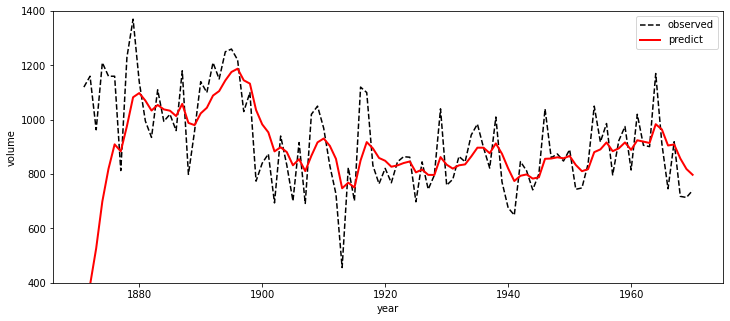

In [7]:
# 可視化
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(year, volume, linestyle='--', color='k', label='observed')
ax.plot(year, x[1:], linewidth=2, color='r', label='predict')
ax.set_ylim(400, 1400)
ax.set_xlabel('year')
ax.set_ylabel('volume')
plt.legend()
plt.show()

In [8]:
# 最初に計算したパラメタと同じ
x1 = calc_state(volume, 0, 1000, 1000, 10000)

# 「状態の予測誤差の分散」の初期値を増やした
x2 = calc_state(volume, 0, 100000, 1000, 10000)

# 状態方程式のノイズの分散をとても小さくした
x3 = calc_state(volume, 1000, 0.1, 0.001, 1000000)

# 観測方程式のノイズの分散をとても小さくした
x4 = calc_state(volume, 1000, 100000, 10000, 100)

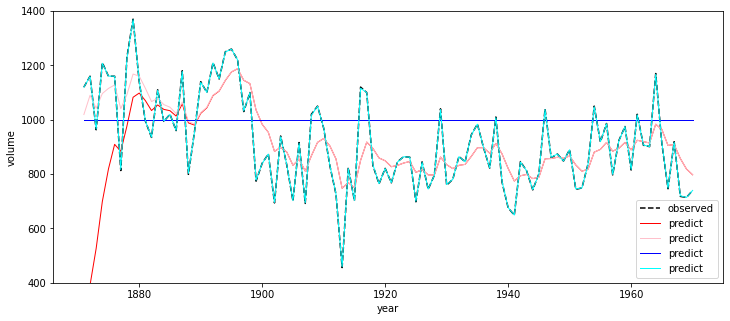

In [9]:
# 可視化
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(year, volume, linestyle='--', color='k', label='observed')
ax.plot(year, x1, linewidth=1, color='r', label='predict')
ax.plot(year, x2, linewidth=1, color='pink', label='predict')
ax.plot(year, x3, linewidth=1, color='blue', label='predict')
ax.plot(year, x4, linewidth=1, color='cyan', label='predict')
ax.set_ylim(400, 1400)
ax.set_xlabel('year')
ax.set_ylabel('volume')
plt.legend()
plt.show()